## CV Assigmnet 2

Name: Md Faizal Karim \
Roll No: 2022121004

All WandB runs can be found here: <a href='https://wandb.ai/fk280/CV-2024-A2/workspace?workspace=user-fk280'>WandB-CV-A2 </a>

## Imports

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from tqdm.notebook import tqdm
import sklearn
import mnist
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
import wandb
from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'

seed = 28
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
if device =='cuda':
    torch.cuda.manual_seed(seed)
    


plt.style.use('seaborn')
device

'cuda'

## Load Data

In [2]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

test_images = mnist.test_images()
test_labels = mnist.test_labels()

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

(-0.5, 27.5, 27.5, -0.5)

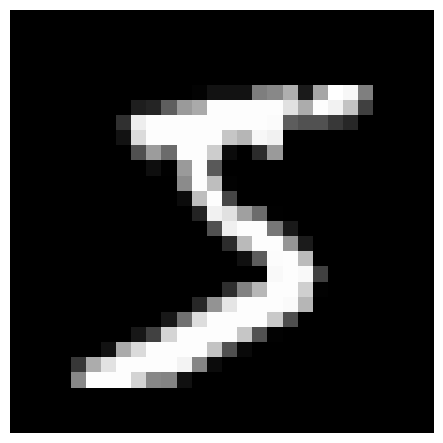

In [3]:
plt.imshow(train_images[0], cmap='gray')
plt.axis('off')

## SIFT-BoVW-SVM

#### Q1 Bag of Visual Word using SIFT features

In [4]:
class KMeansTorch:
    def __init__(self, num_clusters, max_iters=200, device='cuda'):
        self.num_clusters = num_clusters
        self.max_iters = max_iters
        self.device = device
        self.centroids = None

    def forward(self, X):
        X = torch.from_numpy(np.concatenate(X)).to(self.device)
        N, D = X.shape
        self.centroids = X[torch.randperm(N)[:self.num_clusters]].to(self.device)
        
        with torch.no_grad():
            for _ in tqdm(range(self.max_iters)):
                distances = torch.cdist(X, self.centroids)
                assignments = torch.argmin(distances, dim=1)
                for i in range(self.num_clusters):
                    cluster_points = X[assignments == i]
                    if len(cluster_points) > 0:
                        self.centroids[i] = cluster_points.mean(dim=0)

    def fit(self, X):
        self.forward(X)

    def predict(self, X): 
        X = torch.from_numpy(X.astype(np.float32)).to(self.device)
        with torch.no_grad():
            distances = torch.cdist(X, self.centroids)
            assignments = torch.argmin(distances, dim=1)
        return assignments.cpu()


In [5]:
class BoW:
    def __init__(self,
                 images,
                 labels,
                 n_clusters,):

        self.images = images
        self.labels = labels
        self.n_clusters = n_clusters
        self.kmeans = KMeansTorch(num_clusters=self.n_clusters)
        

    def get_sift_features(self, img):
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(img, None)
        return keypoints, descriptors


    def get_all_descriptors(self, imgs):
        all_descriptors, y = [], []
        for i, img in tqdm(enumerate(imgs), total=len(imgs)):
            descriptors = self.get_sift_features(img)[1]
            if descriptors is not None:
                all_descriptors.append(descriptors)
                y.append(self.labels[i])
                
        return all_descriptors, y


    def get_clusters(self, descriptors):
        self.kmeans.fit(descriptors)

    def img2histogram(self, descriptor, kmeans):
        histogram = np.zeros(kmeans.num_clusters)
        word = kmeans.predict(descriptor.astype(np.float64))
        for i in word:
            histogram[i] += 1
        # histogram = np.histogram(word, bins=kmeans.num_clusters, density=False)[0]
        return histogram

    def fit(self, descriptors_path=None):
        if descriptors_path is not None:
            self.descriptors = np.load(descriptors_path, allow_pickle=True)
            print('Descriptors loaded')
        else:
            self.descriptors, self.y = self.get_all_descriptors(self.images)
            print('Descriptors computed')
            

        print('Computing KMeans')
        self.get_clusters(descriptors=self.descriptors)
        print('KMeans Done')

        X = []

        for descriptor in tqdm(self.descriptors):
            X.append(self.img2histogram(descriptor, self.kmeans))

        return np.asarray(X), np.asarray(self.y)



In [6]:

def run_bow(n_clusters=200):
    bag = BoW(images=train_images[:10000],
            labels=train_labels[:10000],
            n_clusters=n_clusters)

    X, y = bag.fit(descriptors_path=None)


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    X_train.shape, X_test.shape, y_train.shape, y_test.shape

    svm_model = SVC()
    svm_model.fit(X_train, y_train)

    return svm_model.score(X_test, y_test)


In [7]:
run_bow(n_clusters=200)

  0%|          | 0/10000 [00:00<?, ?it/s]

Descriptors computed
Computing KMeans


  0%|          | 0/200 [00:00<?, ?it/s]

KMeans Done


  0%|          | 0/9769 [00:00<?, ?it/s]

0.7901740020470829

#### Q2 Different values of number of clusters

In [ ]:
n_clusters = 1
bow_acc = []
bow_clusters = []

for i in range(1, 20):
    bow_acc.append(run_bow(n_clusters))
    bow_clusters.append(n_clusters)
    if i < 10:
        n_clusters += 20
    else:
        n_clusters += 50

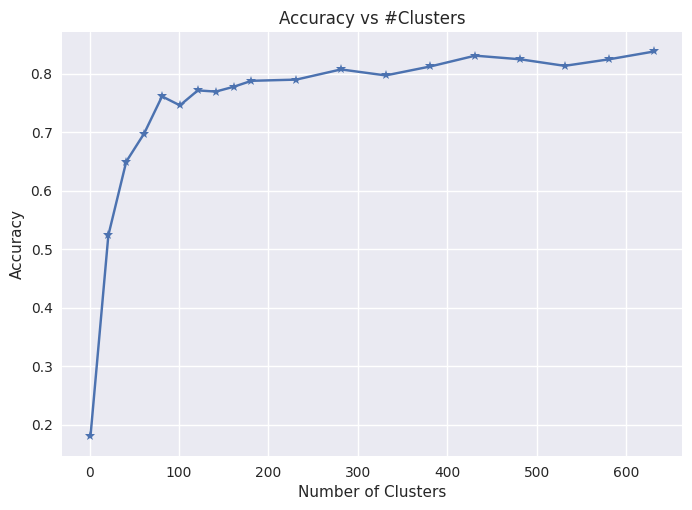

In [62]:
plt.plot(bow_clusters, bow_acc, marker='*')
plt.title('Accuracy vs #Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
plt.show()


#### Q3 Different Hyperparameter Settings

In [ ]:
def run_bow(n_clusters, svm_model):
    bag = BoW(images=train_images[:10000],
            labels=train_labels[:10000],
            n_clusters=n_clusters)

    X, y = bag.fit(descriptors_path=None)


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    X_train.shape, X_test.shape, y_train.shape, y_test.shape

    svm_model.fit(X_train, y_train)

    return svm_model.score(X_test, y_test)


# 1
svm_models = [SVC(C=5, kernel='linear'), SVC(C=10, kernel='linear'), SVC(C=5, kernel='poly', degree=5), 
              SVC(C=10, kernel='poly', degree=7), SVC(C=5, kernel='sigmoid'), SVC(C=10, kernel='sigmoid')]

accs = []

for svm_model in svm_models:
    accs.append(run_bow(n_clusters=300, svm_model=svm_model))
    

In [40]:
titles = ["SVC(C=5, kernel='linear')", "SVC(C=10, kernel='linear')", "SVC(C=5, kernel='poly', degree=5)", 
          "SVC(C=10, kernel='poly', degree=7)", "SVC(C=5, kernel='sigmoid')", "SVC(C=10, kernel='sigmoid')"]

print("Results")
print("="*30)

for (title, acc) in zip(titles, accs):
    print(f"{title}: {acc:.4f}")

Results
SVC(C=5, kernel='linear'): 0.7554
SVC(C=10, kernel='linear'): 0.7492
SVC(C=5, kernel='poly', degree=5): 0.4033
SVC(C=10, kernel='poly', degree=7): 0.1648
SVC(C=5, kernel='sigmoid'): 0.7523
SVC(C=10, kernel='sigmoid'): 0.7369


From the above we can observe that a linear SVM classifier itself gives better performance compared to other high degree SVMs with polynomial kernels. Also, the optimal number of clusters to use is about 350. Clusters more than 300 give similar results although it becomes computationally expensive. 

## CNNs and Transformers

### Q1 DataLoader, Model and Trainer class

In [29]:
from sklearn.model_selection import train_test_split

batch_size = 128
lr = 1e-4

class MNISTDataset(Dataset):
    def __init__(self, images, labels, n_samples=None):
        super().__init__()
        self.images = images
        self.labels = labels
        if n_samples is not None:
            self.images, _, self.labels, _ = train_test_split(self.images, self.labels, train_size=n_samples/len(images), stratify=self.labels)
            
        self.n_samples = len(self.images)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        img = torch.from_numpy(self.images[idx]).view(1, 28, 28)/255.0
        label = torch.tensor(self.labels[idx].astype(np.int64))

        return img.to(torch.float32), label.to(torch.int64)

train_dataset = MNISTDataset(train_images, train_labels)
val_dataset = MNISTDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [5]:
a, b = next(iter(train_loader))
a.shape, b.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [31]:
class LeNet(nn.Module):
    def __init__(self, double_layers=False):
        super().__init__()
        self.block1 = self.get_conv_block(1, 6, kernel_size=5, padding=2, stride=1)
        self.block1_2 = self.get_conv_block(6, 6, kernel_size=3, padding=1, stride=1)
        self.block2 = self.get_conv_block(6, 16, kernel_size=5, stride=1)
        self.block2_2 = self.get_conv_block(16, 16, kernel_size=3, padding=1, stride=1)
        self.block3 = self.get_conv_block(16, 120, kernel_size=5, stride=1)
        self.block3_2 = self.get_conv_block(120, 120, kernel_size=3, padding=1, stride=1)
        
        self.avgpool = nn.AvgPool2d(2)
        
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)
        
        self.double_layers = double_layers

    def get_conv_block(self, in_c, out_c, kernel_size=5, padding=0, stride=1):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.Tanh(),
        )

    def forward(self, x):
        # 1, 28, 28
        x = self.block1(x) # 6, 28, 28
        if self.double_layers:
            x = self.block1_2(x)
        x = self.avgpool(x) # 6, 14, 14
        
        x = self.block2(x) # 16, 10, 10
        if self.double_layers:
            x = self.block2_2(x)
        x = self.avgpool(x) # 16, 5, 5
        
        x = self.block3(x) # 120, 1, 1
        if self.double_layers:
            x = self.block3_2(x)

        x = x.view(-1, 120)

        x = nn.Tanh()(self.fc1(x)) # 84
        x = self.fc2(x) # 10
        return x


In [7]:
model = LeNet()
with torch.no_grad():
    print(model(a).shape)

torch.Size([128, 10])


In [27]:
from sklearn.metrics import accuracy_score

class Trainer:
    def __init__(self,
                 model,
                 train_loader,
                 val_loader,
                 device,
                 logger=None,
                 lr=1e-4):

        self.device = device
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.logger = logger
        self.loss_fxn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = lr)
        self.accuracy_fxn = accuracy_score
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': []
        }

    def training_step(self, x, y):
        y_pred = self.model(x)
        loss = self.loss_fxn(y_pred, y)
        acc = self.accuracy_fxn(y.cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=-1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss, acc

    def val_step(self, x, y):
        with torch.no_grad():
            y_pred = self.model(x)
            loss = self.loss_fxn(y_pred, y)
            acc = self.accuracy_fxn(y.cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=-1))

        return loss, acc

    def go_one_epoch(self, loader, step_fxn):
        loss, acc = 0, 0
        for x, y in loader:
            x, y = x.to(self.device), y.to(self.device)
            loss_batch, acc_batch = step_fxn(x, y)
            loss, acc = loss + loss_batch, acc + acc_batch

        return loss/len(loader), acc/len(loader)

    def train(self, epochs=20):
        for epoch in tqdm(range(epochs)):
            train_loss, train_acc = self.go_one_epoch(self.train_loader, self.training_step)
            val_loss, val_acc = self.go_one_epoch(self.val_loader, self.val_step)

            print(f"[{epoch + 1}] train:[loss:{train_loss:.4f}, acc:{train_acc:.4f}] val:[loss:{val_loss:.4f}, acc:{val_acc:.4f}]")
            
            if self.logger:
                self.logger.log({
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'train_acc': train_acc,
                    'val_acc': val_acc 
                })
                
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            
                
        if self.logger:
            self.logger.finish()

In [ ]:

wandb.init(project='CV-2024-A2', 
           name='LeNet-lr=1e-6',
           config={
               'lr': lr,
               'batch_size': batch_size,
               'optimizer': 'RMSprop',
               'num_conv_layers': 3
           })

In [39]:
trainer = Trainer(
    model=LeNet(),
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    logger=wandb,
    lr=lr
)

In [40]:
trainer.train()

  0%|          | 0/20 [00:00<?, ?it/s]

[1] train:[loss:0.9069, acc:0.7904] val:[loss:0.4859, acc:0.8765]
[2] train:[loss:0.4103, acc:0.8875] val:[loss:0.3339, acc:0.9035]
[3] train:[loss:0.3094, acc:0.9103] val:[loss:0.2651, acc:0.9209]
[4] train:[loss:0.2520, acc:0.9257] val:[loss:0.2171, acc:0.9355]
[5] train:[loss:0.2112, acc:0.9378] val:[loss:0.1840, acc:0.9441]
[6] train:[loss:0.1807, acc:0.9465] val:[loss:0.1575, acc:0.9524]
[7] train:[loss:0.1571, acc:0.9533] val:[loss:0.1399, acc:0.9571]
[8] train:[loss:0.1388, acc:0.9589] val:[loss:0.1224, acc:0.9625]
[9] train:[loss:0.1242, acc:0.9626] val:[loss:0.1113, acc:0.9672]
[10] train:[loss:0.1120, acc:0.9666] val:[loss:0.1018, acc:0.9694]
[11] train:[loss:0.1019, acc:0.9700] val:[loss:0.0929, acc:0.9714]
[12] train:[loss:0.0933, acc:0.9718] val:[loss:0.0851, acc:0.9738]
[13] train:[loss:0.0861, acc:0.9744] val:[loss:0.0804, acc:0.9748]
[14] train:[loss:0.0797, acc:0.9761] val:[loss:0.0740, acc:0.9774]


In [22]:
api = wandb.Api()
run = api.run(f"CV-2024-A2/qph9kyhs")

In [23]:
run

<Run fk280/CV-2024-A2/qph9kyhs (crashed)>

### Q2 Results of different hyperparameters

1. Runs with different batch sizes \
Performance of the models slightly decreases as we increase the batch size. Also, having an extremely large batch size can be impractical at times because of computational resources \
<img src='./plots/bs.png'></img>

2. Runs with different optimizers \
Different optimizers lead to large differences in model performance. This shows that optimizers as hyperparameters are extremely important. \
<img src='./plots/optimizer.png'></img>

3. Runs with different learning rate \
Learning rate also has considerable impact on the training. Having a learning rate in the range of 0.001-0.0001 leads to best results. \
<img src='./plots/lr.png'></img>

Finally, we can conclude that optimizer as well as learning rate are extremely important for the training process. Adam optimizer works the best for this case and learning rate should be about 0.0001 and not too small which would lead to slower convergence rate.




### Q3 Comparison of CNN and BoW

The best performing CNN was with hyperparameters: <b>lr=0.0001, optimizer=adam, batch_size=64</b> and <b>accuracy=98.8%</b>. Meanwhile, the best performing BoW model was with <b>n_clusters=300</b> and <b>accuracy=83.6%</b>.

1. Feature Representation: 
   * CNN extracts hierarchical features automatically from raw data, capturing intricate patterns.
   * BoW relies on handcrafted features, potentially missing nuanced information, leading to a lower accuracy compared to CNN. 
   
2. Training Complexity:
   * CNNs require more extensive training but achieve higher accuracy with large datasets.
   * BoW is computationally efficient but struggles to capture intricate patterns, resulting in lower accuracy despite quicker training.

3. Generalization Ability:
   * CNNs generalize well to diverse data due to learned hierarchical features, providing superior accuracy across various scenarios.
   * BoW may struggle to generalize as effectively, particularly with complex data, limiting its performance in diverse applications.



### Q4 Doubling the number of Layer

In [32]:
trainer = Trainer(
    model=LeNet(double_layers=True),
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    logger=None,
    lr=lr
)

trainer.train()

  0%|          | 0/20 [00:00<?, ?it/s]

[1] train:[loss:1.2269, acc:0.6289] val:[loss:0.5931, acc:0.8401]
[2] train:[loss:0.4576, acc:0.8757] val:[loss:0.3401, acc:0.9046]
[3] train:[loss:0.2975, acc:0.9152] val:[loss:0.2367, acc:0.9306]
[4] train:[loss:0.2173, acc:0.9375] val:[loss:0.1792, acc:0.9481]
[5] train:[loss:0.1720, acc:0.9494] val:[loss:0.1489, acc:0.9563]
[6] train:[loss:0.1437, acc:0.9578] val:[loss:0.1311, acc:0.9614]
[7] train:[loss:0.1253, acc:0.9626] val:[loss:0.1132, acc:0.9660]
[8] train:[loss:0.1109, acc:0.9673] val:[loss:0.1034, acc:0.9692]
[9] train:[loss:0.0997, acc:0.9704] val:[loss:0.0974, acc:0.9704]
[10] train:[loss:0.0911, acc:0.9729] val:[loss:0.0909, acc:0.9705]
[11] train:[loss:0.0832, acc:0.9747] val:[loss:0.0832, acc:0.9737]
[12] train:[loss:0.0765, acc:0.9773] val:[loss:0.0773, acc:0.9750]
[13] train:[loss:0.0710, acc:0.9791] val:[loss:0.0772, acc:0.9750]
[14] train:[loss:0.0658, acc:0.9802] val:[loss:0.0713, acc:0.9763]
[15] train:[loss:0.0613, acc:0.9814] val:[loss:0.0689, acc:0.9779]
[16]

##### Observations
From the above we can conclude that doubling the number of layers doesn't have significant change in the performance of the model. This suggests that we have unnecessary parameters in our model which leads to more complexity, increase in inference time and wastage of computation power. 

Also, increasing model complexity can lead to overfitting of the model on the training set. Fortunately, the dataset we are using has sufficient number of data points, hence chances of overfitting is less. 

### Q5 Changing the number of training samples

In [ ]:
for n_samples in [600, 1800, 6000, 18000, None]:
    train_dataset = MNISTDataset(train_images, train_labels, n_samples=n_samples)
    val_dataset = MNISTDataset(test_images, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    wandb.init(project='CV-2024-A2', 
               name=f'LeNet-n_samples={n_samples}'
               )
    
    trainer = Trainer(
        model=LeNet(),
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        logger=wandb,
        lr=lr
    )
    
    trainer.train()
    

##### Observations
<img src='./plots/training-samples.png'></img>

1. Training with extremely less number of data points (600) leads to poor results (accuracy about 63%).
2. Training with moderate number of data points (1800, 6000) takes more time to reach accuracies greater than 90%.
3. Finally, training with large number of data points leads to faster convergence and high accuracies.

### Q6 Vision Transformer

<img src='./plots/vit.gif'></img>

Different modules in a ViT:

<ol>
    <li> Patch Embeddings: <br>
        - Divides the input image into non-overlapping patches. <br>
        - Each patch is linearly embedded into a vector. <br>
        - Enables the transformer to process local information. <br>
    </li>
    <br>
    <li>Transformer Encoder: <br>
        - Multiple layers of transformer encoder blocks.<br>
        - Each block contains a multi-head self-attention mechanism and position-wise feedforward networks. <br>
        - Captures both local and global relationships in the image. <br>
    </li>
    <br>
    <li>Positional Encoding: <br>
        - Injects positional information into the input sequence. <br>
        - Compensates for the lack of inherent order information in the transformer architecture. <br>
        - Allows the model to distinguish between different positions of patches. <br>
    </li>
    <br>
    <li>Classification Head: <br>
        - Takes the output of the transformer encoder and produces the final predictions. <br>
        - Often includes a linear layer followed by a softmax activation for classification. <br>
    </li>

</ol>


In [35]:
class VIT(nn.Module):
    def __init__(self,
                 patch_size,
                 input_dim, 
                 heads, 
                 mlp_dim, 
                 dropout, 
                 depth,
                 num_patches):
        
        super().__init__()
        self.input_dim = input_dim
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout 
        self.depth = depth  
        self.patch_size = patch_size
        self.num_patches = num_patches
        
        self.patch_embedding = nn.Conv2d(1, self.input_dim, kernel_size=self.patch_size, stride=self.patch_size)
        self.positional_embedding = nn.Parameter(torch.randn(1, self.num_patches, self.input_dim))
        
        self.encoder = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(
                    d_model=self.input_dim,
                    nhead=self.heads,
                    dim_feedforward=self.mlp_dim,
                    dropout=self.dropout
                ),
                num_layers=self.depth
            )
        
        self.fc1 = nn.Linear(self.input_dim, 10)
        
    def forward(self, x):
        # x: bs, 1, 28, 28
        
        x = self.patch_embedding(x) # bs, 256, 7, 7
        x = x.flatten(2).transpose(1, 2) # bs, 49, 256
        
        x = x + self.positional_embedding # bs, 49, 256
        
        x = self.encoder(x) # bs, 49, 256
        x = x.mean(dim=1) # bs, 256
        
        x = self.fc1(x) # bs, 10
        
        return x
                
        

In [36]:
image_size = 28
patch_size = 4
num_classes = 10
input_dim = 256
depth = 4
heads = 4
mlp_dim = 256
dropout = 0.1
num_patches = int((image_size * image_size)/(patch_size * patch_size))

##### Training with 6k samples

In [37]:
wandb.init(project='CV-2024-A2', 
           name='ViT-6K')

train_dataset = MNISTDataset(train_images, train_labels, n_samples=6000)
val_dataset = MNISTDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = VIT(patch_size,
            input_dim, 
            heads, 
            mlp_dim, 
            dropout, 
            depth,
            num_patches)

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    logger=wandb,
    lr=lr
)

trainer.train()


  0%|          | 0/20 [00:00<?, ?it/s]

[1] train:[loss:2.3046, acc:0.1032] val:[loss:2.2909, acc:0.1138]
[2] train:[loss:2.2888, acc:0.1387] val:[loss:2.2707, acc:0.1856]
[3] train:[loss:2.2082, acc:0.2459] val:[loss:2.0819, acc:0.2813]
[4] train:[loss:2.0229, acc:0.2860] val:[loss:1.9723, acc:0.3661]
[5] train:[loss:1.9265, acc:0.3542] val:[loss:1.8742, acc:0.3836]
[6] train:[loss:1.8441, acc:0.4083] val:[loss:1.7937, acc:0.4870]
[7] train:[loss:1.7623, acc:0.4448] val:[loss:1.7214, acc:0.4283]
[8] train:[loss:1.6856, acc:0.4829] val:[loss:1.6406, acc:0.4639]
[9] train:[loss:1.6023, acc:0.5040] val:[loss:1.5650, acc:0.5359]
[10] train:[loss:1.5196, acc:0.5596] val:[loss:1.4776, acc:0.5947]
[11] train:[loss:1.4455, acc:0.5956] val:[loss:1.4060, acc:0.6330]
[12] train:[loss:1.3786, acc:0.6147] val:[loss:1.3334, acc:0.6476]
[13] train:[loss:1.3039, acc:0.6391] val:[loss:1.2644, acc:0.6625]
[14] train:[loss:1.2410, acc:0.6695] val:[loss:1.2062, acc:0.6624]
[15] train:[loss:1.1779, acc:0.6833] val:[loss:1.1382, acc:0.6979]
[16]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


##### Training with 60K samples

In [38]:

wandb.init(project='CV-2024-A2', 
           name='ViT-60K')

train_dataset = MNISTDataset(train_images, train_labels)
val_dataset = MNISTDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = VIT(patch_size,
            input_dim, 
            heads, 
            mlp_dim, 
            dropout, 
            depth,
            num_patches)

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    logger=wandb,
    lr=lr
)

trainer.train()

  0%|          | 0/20 [00:00<?, ?it/s]

[1] train:[loss:1.9048, acc:0.3644] val:[loss:1.3546, acc:0.6539]
[2] train:[loss:1.0723, acc:0.7296] val:[loss:0.8206, acc:0.8015]
[3] train:[loss:0.6918, acc:0.8391] val:[loss:0.5630, acc:0.8719]
[4] train:[loss:0.4976, acc:0.8800] val:[loss:0.4303, acc:0.8975]
[5] train:[loss:0.3914, acc:0.9037] val:[loss:0.3452, acc:0.9168]
[6] train:[loss:0.3230, acc:0.9170] val:[loss:0.2912, acc:0.9275]
[7] train:[loss:0.2762, acc:0.9272] val:[loss:0.2484, acc:0.9355]
[8] train:[loss:0.2396, acc:0.9363] val:[loss:0.2127, acc:0.9425]
[9] train:[loss:0.2164, acc:0.9399] val:[loss:0.2020, acc:0.9431]
[10] train:[loss:0.1943, acc:0.9458] val:[loss:0.1789, acc:0.9509]
[11] train:[loss:0.1791, acc:0.9502] val:[loss:0.1670, acc:0.9519]
[12] train:[loss:0.1663, acc:0.9528] val:[loss:0.1604, acc:0.9539]
[13] train:[loss:0.1539, acc:0.9569] val:[loss:0.1494, acc:0.9571]
[14] train:[loss:0.1441, acc:0.9600] val:[loss:0.1392, acc:0.9581]
[15] train:[loss:0.1355, acc:0.9611] val:[loss:0.1275, acc:0.9637]
[16]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


#### Observations

<img src='plots/vit-2.png'></img>

1. The ViT has a slightly less accuracy compared to our CNN. Also, each epoch of traning took much more time than CNN, suggesting that ViT is computationally more expensive than CNN.
2. With less number of data points (6K), we can see that ViT achieves less accuracy compared to CNN. This shows that ViT is data hungry while CNN can generalize even with a small dataset. 

## Learning and Challenges

Learnings:
1. Using PyTorch for data loading, building model architecture and training it.
2. WandB for logging purposes.
3. Indepth view of Vision Transformer through its implementation.

Challenges:
1. Long training times.
2. Computing shapes of conv layers in CNN model.